In [2]:
import setup_path  # adds project root to sys.path
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

RESULTS_DIR = Path('../Analysis/results')
MODELS = ['gpt-4o', 'claude-3.5-sonnet', 'gemma-3-27b-it', 'qwen2.5-vl-72b-instruct', 'llama-4-maverick']

## Load per-model CSVs
Run `compare_generated_to_truth.py --all-models` first to populate `Analysis/results/`.

In [3]:
dfs = {}
for model in MODELS:
    csv_path = RESULTS_DIR / f'compare_{model}.csv'
    if csv_path.exists():
        dfs[model] = pd.read_csv(csv_path)
    else:
        print(f'Missing: {csv_path}')

print(f'Loaded {len(dfs)} model(s):', list(dfs.keys()))

Loaded 5 model(s): ['gpt-4o', 'claude-3.5-sonnet', 'gemma-3-27b-it', 'qwen2.5-vl-72b-instruct', 'llama-4-maverick']


## Leaderboard
Metrics (lower is better for vol_rel / hausdorff / xi_l2; higher p_value = more similar).

In [4]:
SHAPE_METRICS = ['vol_rel', 'hausdorff', 'xi_l2', 'p_value']

rows = []
for model, df in dfs.items():
    ok   = df[df['status'] == 'ok']
    n    = len(df)
    code_pass = (df['code_success'] == True).sum() / n if n > 0 else float('nan')
    shape_pass = len(ok) / n if n > 0 else float('nan')
    row = {'model': model, 'n_total': n,
           'code_pass_rate': round(code_pass, 3),
           'shape_eval_rate': round(shape_pass, 3)}
    for m in SHAPE_METRICS:
        vals = ok[m].dropna()
        row[f'{m}_mean']   = round(vals.mean(), 4)   if len(vals) else float('nan')
        row[f'{m}_median'] = round(vals.median(), 4) if len(vals) else float('nan')
    rows.append(row)

leaderboard = pd.DataFrame(rows).set_index('model')
leaderboard

,n_total,code_pass_rate,shape_eval_rate,vol_rel_mean,vol_rel_median,hausdorff_mean,hausdorff_median,xi_l2_mean,xi_l2_median,p_value_mean,p_value_median
model,,,,,,,,,,,
gpt-4o,100,0.77,0.77,0.7559,0.2967,25.5983,20.0749,476.7429,33.3259,0.013,0.0
claude-3.5-sonnet,100,0.08,0.07,0.6322,0.6474,29.1725,24.5153,137.6347,62.8249,0.000,0.0
gemma-3-27b-it,100,0.66,0.63,1.6687,0.5706,36.7319,30.0552,167.8217,60.5435,0.000,0.0
qwen2.5-vl-72b-instruct,100,0.98,0.98,0.7213,0.4305,30.0674,26.6516,401.9532,43.2056,0.000,0.0
llama-4-maverick,100,0.60,0.59,1.0678,0.4348,26.6033,23.5637,476.7225,42.3763,0.000,0.0


## Metric distributions per model

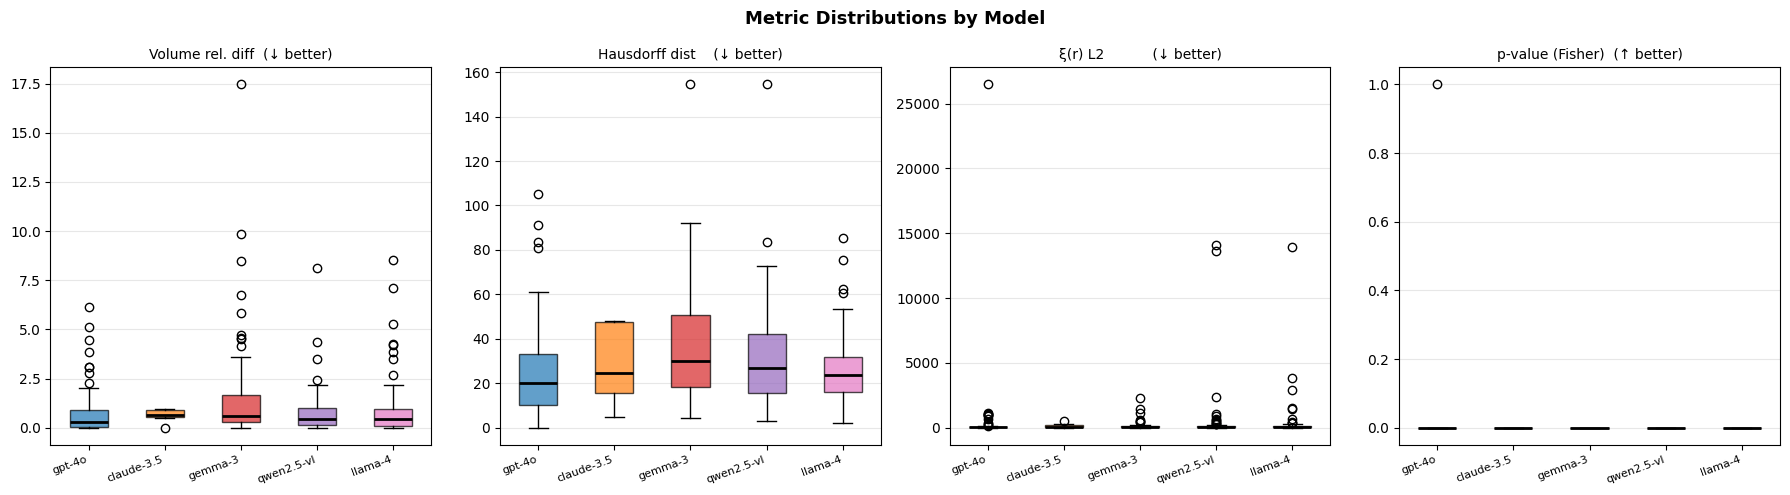

In [5]:
metric_labels = {
    'vol_rel':   'Volume rel. diff  (↓ better)',
    'hausdorff': 'Hausdorff dist    (↓ better)',
    'xi_l2':     'ξ(r) L2           (↓ better)',
    'p_value':   'p-value (Fisher)  (↑ better)',
}

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
model_names = list(dfs.keys())
short_names = [m.split('-')[0] + '-' + m.split('-')[1] if '-' in m else m for m in model_names]

for ax, metric in zip(axes, SHAPE_METRICS):
    data = [dfs[m].query("status == 'ok'")[metric].dropna().values for m in model_names]
    bp = ax.boxplot(data, patch_artist=True, medianprops=dict(color='black', linewidth=2))
    colors = plt.cm.tab10(np.linspace(0, 0.6, len(model_names)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_title(metric_labels[metric], fontsize=10)
    ax.set_xticks(range(1, len(model_names) + 1))
    ax.set_xticklabels(short_names, rotation=20, ha='right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Metric Distributions by Model', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Code pass rate vs shape quality

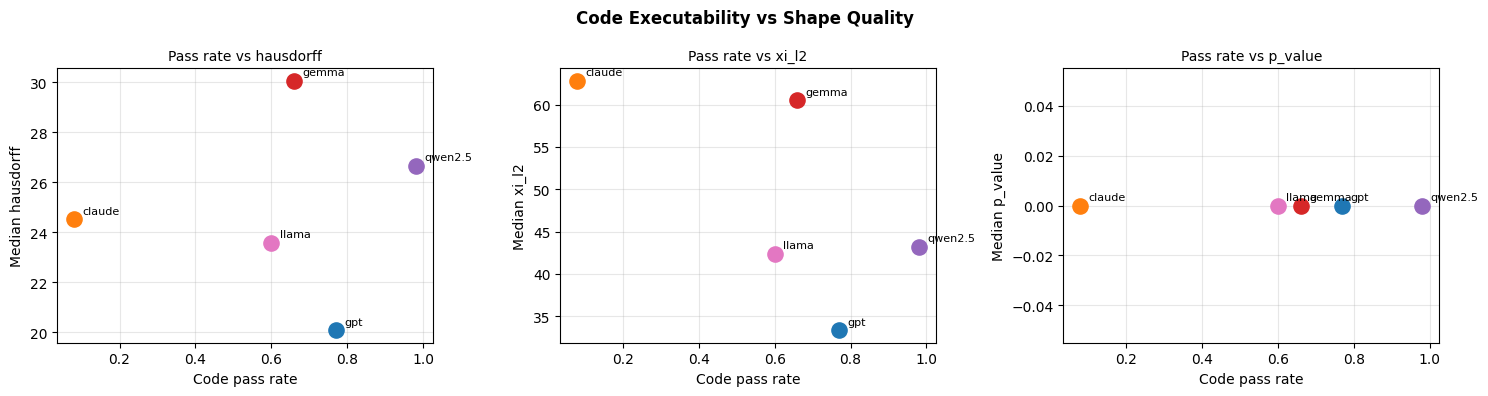

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
shape_metrics_scatter = ['hausdorff', 'xi_l2', 'p_value']
colors = plt.cm.tab10(np.linspace(0, 0.6, len(model_names)))

for ax, metric in zip(axes, shape_metrics_scatter):
    for color, model in zip(colors, model_names):
        df = dfs[model]
        code_pass = (df['code_success'] == True).sum() / len(df)
        ok_vals   = df.query("status == 'ok'")[metric].dropna()
        if len(ok_vals) == 0:
            continue
        shape_score = ok_vals.median()
        ax.scatter(code_pass, shape_score, color=color, s=120, zorder=3,
                   label=model.split('-')[0])
        ax.annotate(model.split('-')[0], (code_pass, shape_score),
                    textcoords='offset points', xytext=(6, 4), fontsize=8)
    ax.set_xlabel('Code pass rate', fontsize=10)
    ax.set_ylabel(f'Median {metric}', fontsize=10)
    ax.set_title(f'Pass rate vs {metric}', fontsize=10)
    ax.grid(alpha=0.3)

plt.suptitle('Code Executability vs Shape Quality', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Error breakdown per model

In [ ]:
from metrics import code_error_bins
import os
import math

GEN_ROOT = Path('../generated')

n_models = len(dfs)
n_cols = 2
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes_flat = axes.flatten() if n_models > 1 else [axes]

for i, (ax, model) in enumerate(zip(axes_flat, model_names)):
    gen_dir = GEN_ROOT / model
    if not gen_dir.exists():
        ax.set_title(f'{model}\n(dir missing)')
        continue
    bins = code_error_bins(str(gen_dir))
    labels = list(bins.keys())
    fracs  = [bins[k]['fraction'] for k in labels]
    bar_colors = ['#2ecc71' if k == 'passed' else '#e74c3c' for k in labels]
    bars = ax.bar(labels, fracs, color=bar_colors, edgecolor='white', linewidth=0.5)
    for bar, frac in zip(bars, fracs):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f'{frac:.0%}', ha='center', va='bottom', fontsize=9)
    ax.set_ylim(0, 1.12)
    ax.set_title(model, fontsize=9)
    ax.set_ylabel('Fraction of files')
    ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)

# Hide any unused subplots
for ax in axes_flat[n_models:]:
    ax.set_visible(False)

plt.suptitle('Code Error Breakdown by Model', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()